In [19]:
!pip install "autora" pykan gplearn feyn
!pip install -U "autora[theorist-bms]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.6 MB/s eta 0:00:00


In [20]:
import pickle

import feyn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from autora.theorist.bms import BMSRegressor
from gplearn.genetic import SymbolicRegressor
from kan import KAN, create_dataset
from matplotlib import font_manager
from sklearn.metrics import mean_squared_error, r2_score

# Comparison of Symbolic Regression using Kolmogorov-Arnold Networks (KANs), Genetic Programming methods and Bayes-based methods

In this notebook, we will compare three **symbolic regression** techniques for learning this **univariate** mathematical function:

$$
y = x^2 + x + 1
$$

1. **Kolmogorov-Arnold-Networks (KAN)**: We will train a KAN using the official **PyKAN** library, to perform symbolic regression.

2. **Genetic Programming**: We will use the **gplearn** library, which implements genetic programming, to find a symbolic representation of the function using evolutionary techniques.   

3. **Bayesian Symbolic Regression (BSR)**: We will use the [autora](https://pypi.org/project/autora/) library to solve the symbolic regression task using the Bayesian approach.


## Dataset definition and plotting

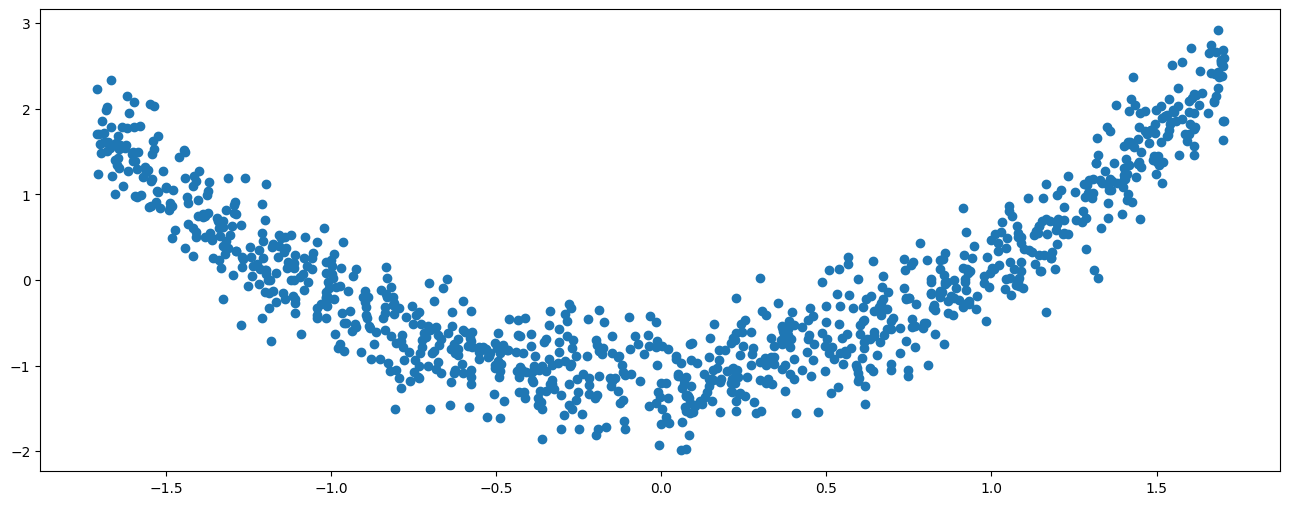

In [7]:
quadratic = lambda x: x ** 2 + x + 1
noise_std = .35
dataset = create_dataset(quadratic, n_var=1, ranges=[-10, 10], train_num=1000, test_num=500,
                         normalize_label=True, normalize_input=True)
dataset['train_label'] += np.random.normal(0, noise_std, (1000, 1))
Xs, Ys = dataset['train_input'], dataset['train_label']

fig, ax = plt.subplots()
ax.scatter(Xs, Ys)
fig.set_size_inches(16, 6)
plt.show()

## 1. Using a KAN

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.45e-01 | test_loss: 2.06e-02 | reg: 4.99e+00 | : 100%|█| 20/20 [00:04<00:00,  4.40it


saving model version 0.1


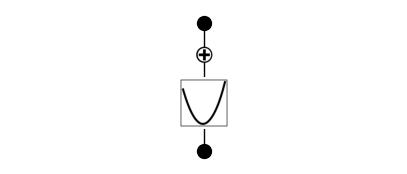

In [8]:
kan_model = KAN(width=[1, 1], grid=3, k=3)
kan_model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001, lamb_entropy=4)
kan_model.plot()

In [9]:
kan_model.suggest_symbolic(0, 0, 0)
kan_model.auto_symbolic()
pass

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999934 -13.691920           2                2   -1.138384
1       sin    0.999746 -11.885681           2                2   -0.777136
2       cos    0.999742 -11.864043           2                2   -0.772809
3  gaussian    0.999891 -13.040888           3                3   -0.208178
4         0    0.000000   0.000014           0                0    0.000003
fixing (0,0,0) with x^2, r2=0.9999344348907471, c=2
saving model version 0.2


## 2. Using a Gplearn

In [10]:
# Configuration of the symbolic regressor
genetic_model = SymbolicRegressor(
    population_size=2000,
    generations=20,
    tournament_size=30,
    stopping_criteria=0.01,
    const_range=(-1.0, 1.0),
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01,
    random_state=0
)

In [11]:
genetic_model.fit(Xs, Ys)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41           7551.2        7         0.380742         0.334788     58.82s
   1     9.63          1.69581        5         0.336607         0.344353     33.30s
   2     7.95          5.71808       13         0.297181         0.292437     24.36s
   3     7.66          1.66844        9         0.289629         0.287356     22.63s
   4     5.65          1.13926        9         0.286949         0.311473     20.34s
   5     5.43          1.01164        9         0.285625         0.323397     19.64s
   6     6.41          1.22227        9         0.283614         0.341493     17.92s
   7     7.07          1.00453        9         0.285018         0.328853     16.47s
   8     7.21          2.03497        7         0.286108         0.364459  

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.1,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=2000,
                  random_state=0, stopping_criteria=0.01, tournament_size=30,
                  verbose=1)

## 3. Using BMS Regressor

In [12]:
bms_model = BMSRegressor(
    epochs=200,
    ts=[1.0] + [1.04 ** k for k in range(1, 20)],
)

In [13]:
bms_model.fit(Xs, Ys)

100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


(cos(cosh(X0)) * -2.02)

## 4. Using QLattice

In [21]:
ql = feyn.QLattice()
data = pd.DataFrame({
    'x': Xs.flatten(),
    'y': Ys.flatten()
})
qlattice_models = ql.auto_run(data, output_name='y', n_epochs=20)

In [22]:
qlattice_models[0].fit(data)
with open("univariate_qlattice_model.pkl", "wb") as f:
    pickle.dump(qlattice_models, f)

In [23]:
sympy_model = qlattice_models[0].sympify(signif=2)
sympy_model.as_expr()

1.1*(-x - 0.08)**2 - 1.1

## Comparison of model results

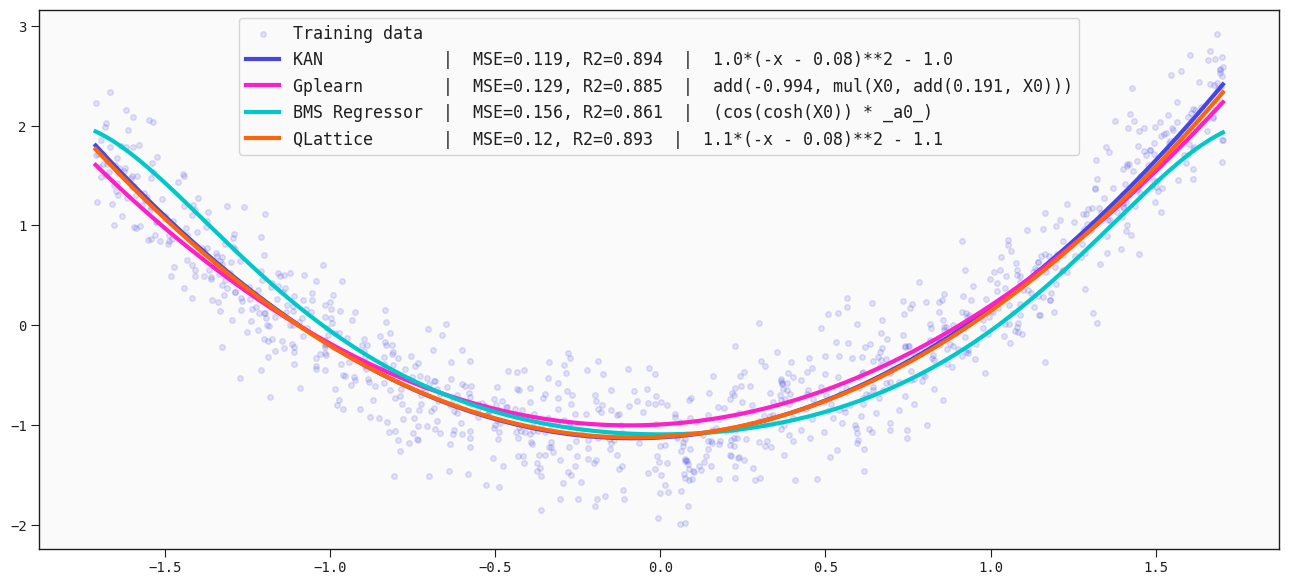

In [24]:
# Get the models predictions
with torch.no_grad():
    kan_pred = kan_model(Xs)
    genetic_pred = genetic_model.predict(Xs)
    bms_pred = bms_model.predict(Xs)
    qlattice_pred = qlattice_models[0].predict(pd.DataFrame({
        'x': Xs.flatten(),
    }))

models = [('KAN', kan_pred, kan_model.symbolic_formula(var=['x'])[0][0].evalf(1)),
          ('Gplearn', genetic_pred, genetic_model._program),
          ('BMS Regressor', bms_pred, bms_model.model_),
          ('QLattice', qlattice_pred, qlattice_models[0].sympify(signif=2))]
fig, ax = plt.subplots()
ax.scatter(Xs, Ys, label='Training data', alpha=0.15)
for pred in models:
    sorted_idx = np.argsort(Xs[:, 0])
    mse, r2 = mean_squared_error(Ys, pred[1]), r2_score(Ys, pred[1])
    ax.plot(Xs[sorted_idx], pred[1][sorted_idx],
            label=f'{pred[0]}{" " * (max(map(lambda x: len(x[0]), models)) - len(pred[0]))}  |  MSE={round(mse, 3)}, R2={round(r2, 3)}  |  {pred[2]}')

fig.set_size_inches(16, 7)
plt.legend(prop=font_manager.FontProperties(family='monospace', size=12))
plt.show()